<h1>Battle of Neighbourhoods</h1>

***

Importing required packages and modules

In [1]:
#!pip install folium

import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import statistics
import folium
import json
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

<h3>Locational Data</h3>

Obtaining the Data Table from Wikipedia

In [2]:
url = 'https://en.wikipedia.org/wiki/M_postcode_area'
w_url = requests.get(url).text

soup = BeautifulSoup(w_url, 'lxml')
table = soup.find('table', {'class':'wikitable sortable'})

Parsing the wikipedia table and storing data in a Pandas Dataframe

In [3]:
_rows_html = table.findAll('td')
_rows = []

#getting table data
for r in _rows_html:
    _rows.append(r.getText())

#processing all postcodes
_postcodes = _rows[::4]
postcodes = []
for p in _postcodes:
    postcodes.append(p[:len(p)-1])

#processing all neighbourhoods
_neighbourhoods = _rows[2::4]
neighbourhoods = []
for n in _neighbourhoods:
    neighbourhoods.append(n[:len(n)-1])

#compiling all data into a Dataframe
df_wiki = pd.DataFrame(columns=['Postcodes', 'Neighbourhoods'])
df_wiki['Postcodes'] = postcodes
df_wiki['Neighbourhoods'] = neighbourhoods

df_wiki.head()

,Postcodes,Neighbourhoods
0,M1,"Piccadilly, City Centre, Market Street"
1,M2,"Deansgate, City Centre"
2,"M3(Sectors 1, 2, 3, 4 and 9)","City Centre, Deansgate, Castlefield"
3,"M3(Sectors 5, 6 and 7)","Blackfriars, Greengate, Trinity"
4,M4,"Ancoats, Northern Quarter, Strangeways"


Cleaning the Neighbourhoods Dataframe

In [4]:
df_wiki.drop([43, 44, 45, 46, 47, 48, 51], axis=0, inplace=True)
df_wiki.head()

,Postcodes,Neighbourhoods
0,M1,"Piccadilly, City Centre, Market Street"
1,M2,"Deansgate, City Centre"
2,"M3(Sectors 1, 2, 3, 4 and 9)","City Centre, Deansgate, Castlefield"
3,"M3(Sectors 5, 6 and 7)","Blackfriars, Greengate, Trinity"
4,M4,"Ancoats, Northern Quarter, Strangeways"


In [5]:
df_wiki.at[2, 'Postcodes'] = 'M3'
df_wiki.at[3, 'Postcodes'] = 'M3'

df_wiki.at[2, 'Neighbourhoods'] = df_wiki.at[2, 'Neighbourhoods'] + str(', ') + df_wiki.at[3, 'Neighbourhoods'] 
df_wiki.drop([3], inplace=True)
df_wiki.reset_index(drop=True, inplace=True)

df_wiki.head()

,Postcodes,Neighbourhoods
0,M1,"Piccadilly, City Centre, Market Street"
1,M2,"Deansgate, City Centre"
2,M3,"City Centre, Deansgate, Castlefield, Blackfri..."
3,M4,"Ancoats, Northern Quarter, Strangeways"
4,M5,"Ordsall, Seedley, Weaste, University"


Importing 'open_postcode_geo.csv' which contains all Coordinates and Mapping data corresponding to each Postcode

Cell is hidden as it contains essential IBM Watson Credentials

In [6]:
# The code was removed by Watson Studio for sharing.

Importing data stored in 'body' as CSV data into a Pandas Dataframe

In [7]:
df_data_1 = pd.read_csv(body)
df_data_1.columns = ['_Postcode', 'Status', 'Usertype', 'Easting', 'Northing', 'Positional Quality', 'Country', 'Latitude', 'Longitude', 'Postcode', 'Postcode7', 'Postcode8', 'Postcode Area', 'Postcode District', 'Postcode Sector', 'Outcode', 'Incode']

def ext_coord(outcode):
    _lat = df_data_1['Latitude'][df_data_1['Outcode'] == outcode][df_data_1['Status'] == 'live'].reset_index(drop=True)
    _lng = df_data_1['Longitude'][df_data_1['Outcode'] == outcode][df_data_1['Status'] == 'live'].reset_index(drop=True)
    lat = _lat.values.astype('float32')
    lng = _lng.values.astype('float32')
    coord = [lat.mean(), lng.mean()]
    #print(coord)
    return coord
coord = []
for p in df_wiki.Postcodes.values:
    coord.append(ext_coord(p))

print(coord)

[[53.477627, -2.236232], [53.480389, -2.2445328], [53.483597, -2.2527094], [53.484955, -2.2300625], [53.479332, -2.2838867], [53.492668, -2.2991822], [53.505508, -2.2625489], [53.508678, -2.2401695], [53.52203, -2.213937], [53.47892, -2.1813598], [53.464272, -2.2021358], [53.4604, -2.2154427], [53.448448, -2.2257957], [53.467117, -2.2514601], [53.455009, -2.2645085], [53.467957, -2.3204226], [53.461315, -2.1705341], [53.436394, -2.1962998], [53.424194, -2.2326567], [53.438007, -2.2729595], [53.385872, -2.2600372], [53.399544, -2.2889388], [53.551289, -2.1981208], [53.5284, -2.2757444], [53.562305, -2.3349748], [53.512196, -2.3364415], [53.514641, -2.3992801], [53.508423, -2.4582131], [53.484375, -2.3555038], [53.419254, -2.4243894], [53.45089, -2.3095911], [53.420952, -2.3263037], [53.456547, -2.1186979], [53.507198, -2.154865], [53.532421, -2.4233065], [53.504219, -2.1907771], [53.450962, -2.3655257], [53.483738, -2.1493642], [53.440762, -2.4271507], [53.547482, -2.2904348], [53.52585

Adding Latitudes and Longitudes to their corresponding Postcodes in the main Dataframe

In [8]:
df_wiki['Latitude'] = [c[0] for c in coord]
df_wiki['Longitude'] = [c[1] for c in coord]
df_wiki.head()

,Postcodes,Neighbourhoods,Latitude,Longitude
0,M1,"Piccadilly, City Centre, Market Street",53.477627,-2.236232
1,M2,"Deansgate, City Centre",53.480389,-2.244533
2,M3,"City Centre, Deansgate, Castlefield, Blackfri...",53.483597,-2.252709
3,M4,"Ancoats, Northern Quarter, Strangeways",53.484955,-2.230062
4,M5,"Ordsall, Seedley, Weaste, University",53.479332,-2.283887


Plotting Data on Folium Map

In [9]:
mc_lat = 53.4808 
mc_lng = -2.2426
map_mc = folium.Map(location=[mc_lat, mc_lng], zoom_start=11)

for lat, lng, neighborhood in zip(df_wiki['Latitude'], df_wiki['Longitude'], df_wiki['Neighbourhoods']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mc)  
    
map_mc

<h3>Traffic Data</h3>

Obtained by analysing the nearby venues and checking for hotspots such as Supermarkets or Museums as well Transportation for accessibility

<h5>Requesting data from Foursquare API</h5>

Setting up Foursquare API Credentials (Hidden Cell)

In [10]:
# The code was removed by Watson Studio for sharing.

Getting a List of venues with Categories that contain words from the Search List

In [11]:
#list of words to look for amongst venue categories
search_list = ['Bus ', 'Train ', 'Metro ', 'Subway ', ' Transport', ' Station', 'Supermarket', 'Rest ', ' Museum', 'Airport']


def getTrafficVenues(names, latitudes, longitudes, radius=500, LIMIT=50):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        for v in results:
            for s in search_list:
                if s in v['venue']['categories'][0]['name']:
                    venues_list.append([(
                        name, 
                        lat, 
                        lng, 
                        v['venue']['name'], 
                        v['venue']['location']['lat'], 
                        v['venue']['location']['lng'],  
                        v['venue']['categories'][0]['name'])])
                else:
                    continue

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
mc_venues = getTrafficVenues(names=df_wiki['Neighbourhoods'],
                                   latitudes=df_wiki['Latitude'],
                                   longitudes=df_wiki['Longitude']
                                  )

Checking obtained list of venues

In [13]:
print(mc_venues.shape)
mc_venues.head()

(49, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"City Centre, Deansgate, Castlefield, Blackfri...",53.483597,-2.252709,People's History Museum,53.481498,-2.252729,History Museum
1,"Higher Broughton, Cheetwood, Lower Broughton, ...",53.505508,-2.262549,X43 Bus Stop,53.502450,-2.258157,Bus Stop
2,"Crumpsall, Cheetham Hill",53.508678,-2.240170,Abraham Moss Metrolink Station,53.510748,-2.235814,Tram Station
3,"Crumpsall, Cheetham Hill",53.508678,-2.240170,Tram to Piccadilly,53.508829,-2.233102,Light Rail Station
4,"Ardwick, Longsight, Chorlton-on-Medlock",53.464272,-2.202136,Hyde Rd/Pottery Ln (Bus Stop),53.465454,-2.197459,Bus Stop


Preparing data for clustering using One-Hot Encoding

In [14]:
# one hot encoding
mc_onehot = pd.get_dummies(mc_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
mc_onehot['Neighborhood'] = mc_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [mc_onehot.columns[-1]] + list(mc_onehot.columns[:-1])
mc_onehot = mc_onehot[fixed_columns]

print(mc_onehot.shape)
mc_onehot.head()

(49, 12)


,Neighborhood,Airport,Airport Lounge,Airport Service,Bus Station,Bus Stop,Gas Station,History Museum,Light Rail Station,Supermarket,Train Station,Tram Station
0,"City Centre, Deansgate, Castlefield, Blackfri...",0,0,0,0,0,0,1,0,0,0,0
1,"Higher Broughton, Cheetwood, Lower Broughton, ...",0,0,0,0,1,0,0,0,0,0,0
2,"Crumpsall, Cheetham Hill",0,0,0,0,0,0,0,0,0,0,1
3,"Crumpsall, Cheetham Hill",0,0,0,0,0,0,0,1,0,0,0
4,"Ardwick, Longsight, Chorlton-on-Medlock",0,0,0,0,1,0,0,0,0,0,0


In [15]:
mc_grouped = mc_onehot.groupby('Neighborhood').mean().reset_index()
mc_grouped.rename(columns={'Neighborhood':'Neighbourhoods'}, inplace=True)
print(mc_grouped.shape)

(24, 12)


Preparing data for final Clustering

In [16]:
df_final = pd.merge(df_wiki, mc_grouped, on='Neighbourhoods', how='left')
df_final.fillna(0.00, inplace=True)
print(df_final.shape)

(44, 15)


Final Dataframe ready for KMeans Clustering

In [17]:
df_final.head()

,Postcodes,Neighbourhoods,Latitude,Longitude,Airport,Airport Lounge,Airport Service,Bus Station,Bus Stop,Gas Station,History Museum,Light Rail Station,Supermarket,Train Station,Tram Station
0,M1,"Piccadilly, City Centre, Market Street",53.477627,-2.236232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,M2,"Deansgate, City Centre",53.480389,-2.244533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,M3,"City Centre, Deansgate, Castlefield, Blackfri...",53.483597,-2.252709,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,M4,"Ancoats, Northern Quarter, Strangeways",53.484955,-2.230062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,M5,"Ordsall, Seedley, Weaste, University",53.479332,-2.283887,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h3>Clustering of Data</h3>
    
 Clustering of Data based on nearby hotspot and transportation

In [18]:
# set number of clusters
kclusters = 5

mc_clustering = df_final.drop(['Neighbourhoods', 'Postcodes'], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(mc_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 4, 2, 0, 0, 4, 4, 0, 0, 4, 0, 1, 0, 0, 0, 2, 2, 1,
       0, 0, 1, 0, 0, 3, 0, 3, 1, 0, 1, 0, 2, 0, 1, 1, 0, 1, 2, 0, 0], dtype=int32)

Adding cluster labels to the Main dataframe

In [19]:
df_final['Cluster'] = kmeans.labels_
df_final

,Postcodes,Neighbourhoods,Latitude,Longitude,Airport,Airport Lounge,Airport Service,Bus Station,Bus Stop,Gas Station,History Museum,Light Rail Station,Supermarket,Train Station,Tram Station,Cluster
0,M1,"Piccadilly, City Centre, Market Street",53.477627,-2.236232,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0
1,M2,"Deansgate, City Centre",53.480389,-2.244533,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0
2,M3,"City Centre, Deansgate, Castlefield, Blackfri...",53.483597,-2.252709,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,1.0,0.0,0.000000,0.000000,0.000000,0
3,M4,"Ancoats, Northern Quarter, Strangeways",53.484955,-2.230062,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0
4,M5,"Ordsall, Seedley, Weaste, University",53.479332,-2.283887,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0
5,M6,"Pendleton, Irlams o' th' Height, Langworthy, S...",53.492668,-2.299182,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0
6,M7,"Higher Broughton, Cheetwood, Lower Broughton, ...",53.505508,-2.262549,0.000000,0.000000,0.000000,0.000000,1.00,0.000000,0.0,0.0,0.000000,0.000000,0.000000,4
7,M8,"Crumpsall, Cheetham Hill",53.508678,-2.240170,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.5,0.000000,0.000000,0.500000,2
8,M9,"Harpurhey, Blackley",53.522030,-2.213937,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0
9,M11,"Clayton, Openshaw, Beswick",53.478920,-2.181360,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0


Plotting all Clusters on the Folium Map

In [20]:
# create map
map_clusters = folium.Map(location=[mc_lat, mc_lng], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_final['Latitude'], df_final['Longitude'], df_final['Neighbourhoods'], df_final['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Cluster 0

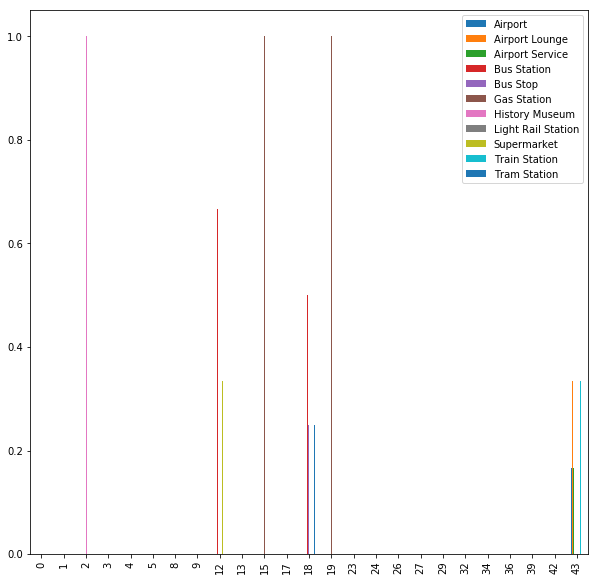

In [60]:
df_0 = df_final[df_final['Cluster'] == 0].drop(['Cluster', 'Latitude', 'Longitude'], 1)
df_0.plot.bar(figsize=(10, 10))

Cluster 1

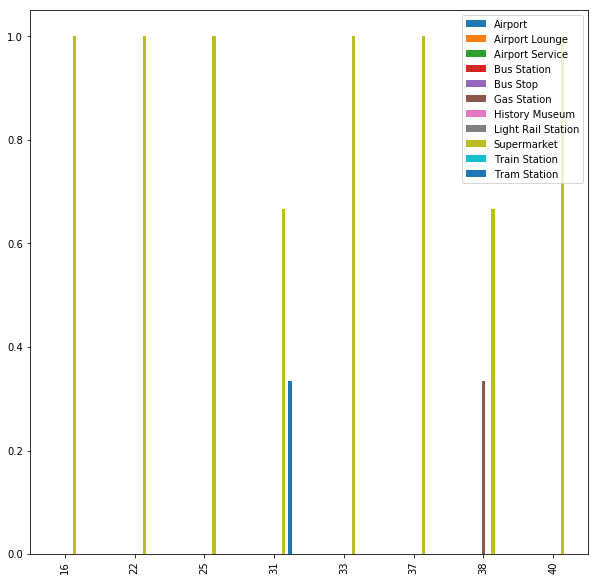

In [46]:
df_1 = df_final[df_final['Cluster'] == 1].drop(['Cluster', 'Latitude', 'Longitude'], 1)
df_1.plot.bar(figsize=(10, 10))

Cluster 2

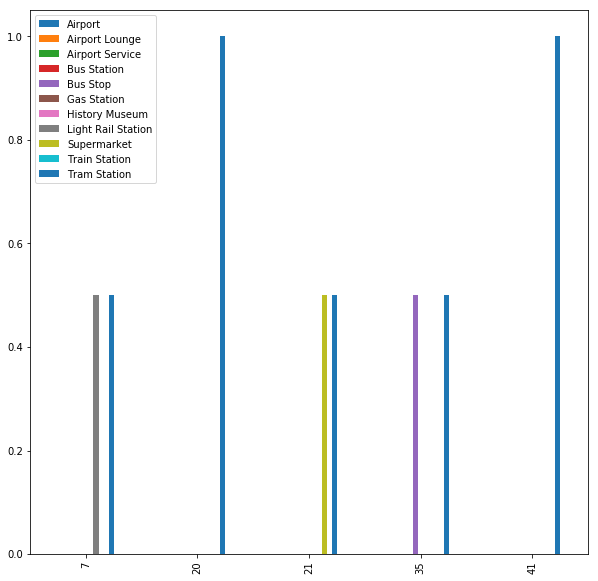

In [47]:
df_2 = df_final[df_final['Cluster'] == 2].drop(['Cluster', 'Latitude', 'Longitude'], 1)
df_2.plot.bar(figsize=(10, 10))

Cluster 3

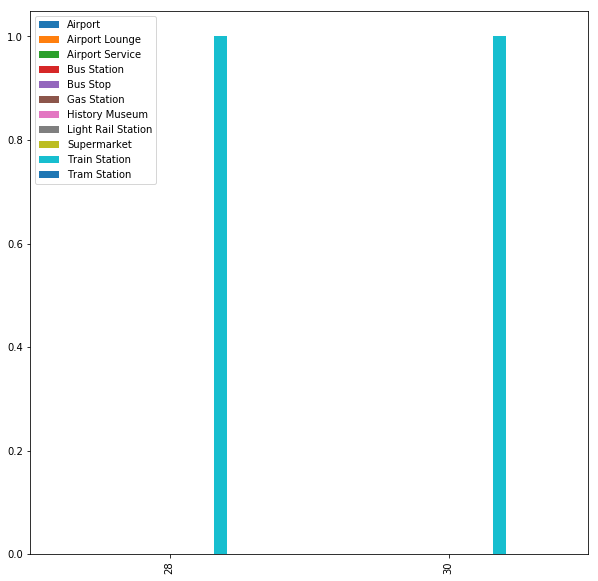

In [48]:
df_3 = df_final[df_final['Cluster'] == 3].drop(['Cluster', 'Latitude', 'Longitude'], 1)
df_3.plot.bar(figsize=(10, 10))

Cluster 4

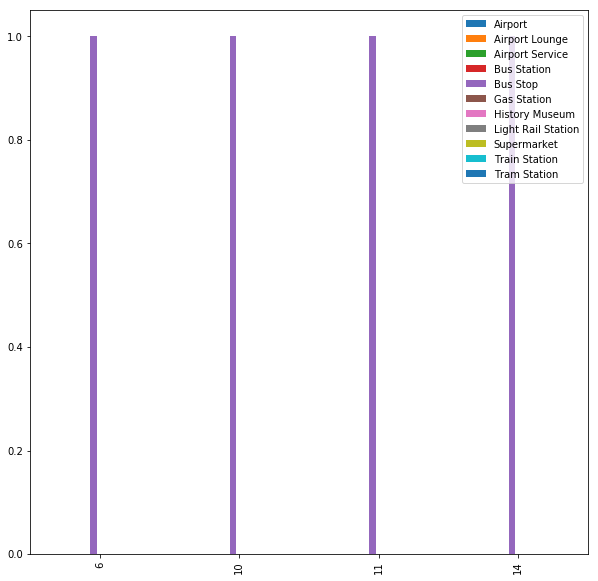

In [49]:
df_4 = df_final[df_final['Cluster'] == 4].drop(['Cluster', 'Latitude', 'Longitude'], 1)
df_4.plot.bar(figsize=(10, 10))

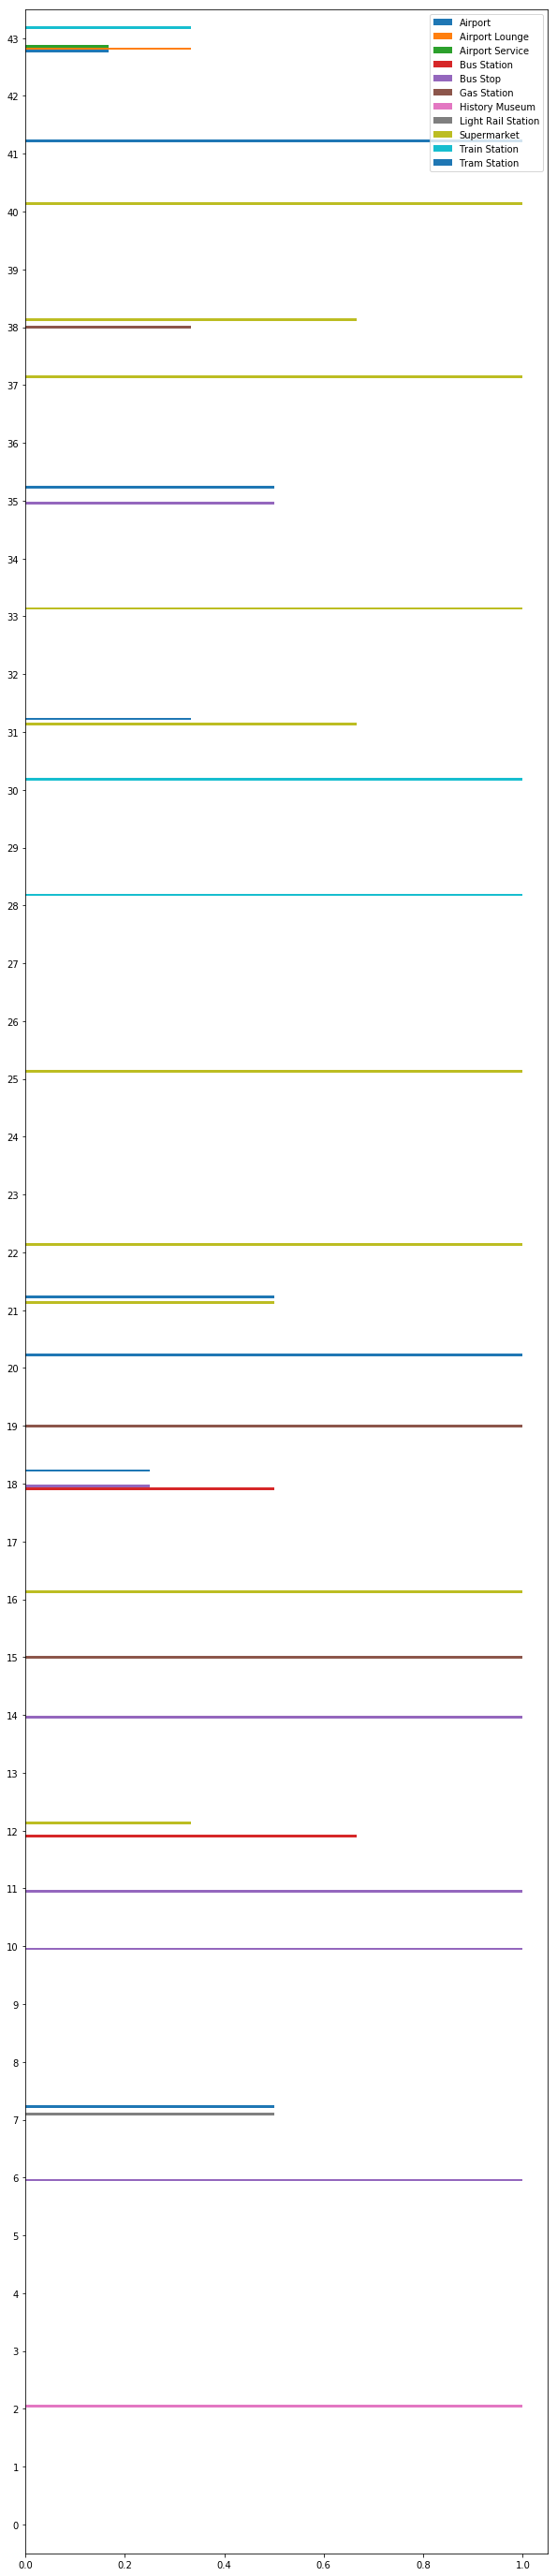

In [59]:
df_final.drop(['Cluster', 'Latitude', 'Longitude'], 1).plot.barh(figsize=(10, 50))

<h3>Analysis</h3>

On analysing each cluster and the overall dataset, the following can be suggested:-
    
    1. Cluster 0 contains the neighbourhoods with lower than other but better overall traffic
    2. Cluster 1 contains the neighbourhoods with occurence of supermarkets thereby guaranteeing good traffic
    3. Cluster 2 contains the neighbourhoods connected with Tram Stations thus providing good accessibility
    4. Cluster 3 contains the neighbourhoods connected with a Train Station which may contribute to higher number of visitors from out of station
    5. Cluster 4 contains the neighbourhoods connected with Bus Stops which suggest a very good inter and intra city connectivity

<h5>Recommendation</h5>

The seemingly best neighbourhood to open a food business is near The Manchester Airport as it provides good connectivity and also ensures a high 
human traffic due to the presence of an Airport thus also guaranteeing new and tourist visitors.